<a href="https://colab.research.google.com/github/avinashmane/colab/blob/master/1.1_strava_likers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup Code/Parameters
* Setup
    * needs
        * auth
        * gsheet auth
        * cfg_strava
* updates sheets
* Todo
    * low: error: location not found 

## Config

In [1]:
repo='https://github.com/avinashmane/colab.git'
CONFIG_FILE='config.yaml'


#clone report for colab
import yaml,os,sys,datetime,time

#setup directories
if os.name=='nt':
    pass
else:               #colab setup below
    if not os.path.exists('./repo') :
        !git clone $repo repo
        sys.path.append("repo/lib")
        sys.path.append('repo')       
    
    # to update APT if not updated
    path='/var/lib/apt/lists'
    if (datetime.datetime.now()-
        datetime.datetime.strptime(time.ctime(os.path.getmtime(path)), "%c")).days:
      !apt update
    
    if not os.path.exists('drive'):
        from google.colab import drive
        drive.mount('/content/drive')
    if not os.path.exists('m'):
      !ln -sd '/content/drive/MyDrive/m/' m
    
sys.path.append('lib')
# sys.path.append(LIB)

import utils
cfg=utils.setup_env(CONFIG_FILE)  #auth_file defaulted from {AUTH}/auth/yaml

for x in cfg['env'][os.name]: 
    # os.environ[x]=cfg['env'][os.name][x]
    globals()[x]=cfg['env'][os.name][x]

#need to use following for each sheet
service_account_file=f'{os.environ["AUTH"]}/{cfg["AUTH"]["service_accounts"]["indiathon"]}'

## Code

In [2]:
import yaml
from datetime import datetime
import os
from nerodia.browser import Browser
import nerodia
import re
import logging
from IPython.display import Image, Markdown
import pandas as pd

import utils
import importlib
importlib.reload(utils)

import socialmediasite 
importlib.reload(socialmediasite)
Strava=socialmediasite.Strava
SocialMediaSite=socialmediasite.SocialMediaSite


In [3]:
"reach gsheet"

import gsheets
Gsheet=gsheets.Gsheet


# Process
## Create headless

In [4]:
" Test Selenium headless"

if True:
    import json
    env_var="BROWSER_SESSIONS"
    if os.name=='nt':
        b=Browser('chrome')
    else:

        from selenium import webdriver

        chrome_options = webdriver.ChromeOptions()
        chrome_options.add_argument('--headless')
        chrome_options.add_argument('--no-sandbox')
        chrome_options.add_argument('--disable-dev-shm-usage')
        # b =webdriver.Chrome('chromedriver',options=chrome_options)
        b=Browser('chrome',options=chrome_options,)
    
    utils.setLogger(f"{LOG}/strava-automation.log")
    

2022-10-21 15:21:31:INFO:Logger file: c:/m/logging/strava-automation.log


In [5]:

strava=Strava(b,                                                 #authFile=f'{AUTH}/auth.yaml',
              cfg=cfg,
              delay=.5)

df_mc=Gsheet(cfg['sheets']['stravasync']['url'],service_account_file=service_account_file
            ).getSheetDf(cfg['sheets']['stravasync']['tab'],start='A10')
promoSheet=Gsheet(cfg['sheets']['StravaPromoLog']['url'],service_account_file=service_account_file)
strava.logGSheet = promoSheet.getSheetByTitle('StravaPromoLog') 
strava.promoCommentLog = promoSheet.getSheetByTitle('PromoCommentLog')
sessionGSheet = promoSheet.getSheetByTitle('SessionLog')

strava.promoCommentedIds=list(strava.promoCommentLog.get_as_df().id.values)
strava.StravaMembers=df_mc.query('strava=="strava"').id.values

%env COUNTER_PROMO_COMMENT 0

env: COUNTER_PROMO_COMMENT=0


# A. Mileage Certificates

In [6]:
strava.login("mileage_league_strava")

In [7]:
certSheet=Gsheet(cfg['sheets']['certs']['url'],service_account_file=service_account_file)
certTab=certSheet.getSheetByTitle(cfg['sheets']['certs']['tab'])
df_cert=certTab.get_as_df().query("comment_text!='' and Activity==''"
                                   ).reset_index()
cols={x:df_cert.columns.get_loc(x)+1 for x in ['comment_ts','comment_text']}
# display(cols)
# merge
_df=df_cert.merge(df_mc[['Email','profile','strava']],on='Email')

c:\sw\python37\lib\site-packages\pygsheets\worksheet.py:1477: UserWarning: At least one column name in the data frame is an empty string. If this is a concern, please specify include_tailing_empty=False and/or ensure that each column containing data has a name.
  warnings.warn('At least one column name in the data frame is an empty string. If this is a concern, please specify include_tailing_empty=False and/or ensure that each column containing data has a name.')


In [8]:
_df['index 	CertType 	Email 	Milestone 	Name 	Date 	ID 	Team	comment_ts 	Activity 		profile 	strava'.split()]

,index,CertType,Email,Milestone,Name,Date,ID,Team,comment_ts,Activity,profile,strava
0,1373,WalkDist,umesh.divekar777@gmail.com,500,Umesh,9/20/2022,1H4nFtV4ptD4bYsiMuowoUMasXylDg9Ti,A,,,https://runkeeper.com/user/2459972584,runkeeper


In [9]:
if True:
    from pprint import pprint as pp

    for i,cert in _df.query("strava=='strava'").iterrows():
        # print (cert['index'],cert.profile,cert.comment_text)
        remark=''
        try:

            if not cert.profile: 
                logging.warning(f"{cert.Row},{cert.Name},{cert.profile} : {cert['index']} no profle")
                remark='No profile'
                continue
            b.goto(cert.profile)
            # url=f"https://www.strava.com/activities/{x['activity_id']}"
            if True:
                commentEl=b.button(data_testid="comment_button")
                strava.postComment(commentEl,cert.comment_text)
                logging.info(f"{cert.Row},{cert.Name},{cert.profile} :{cert.comment_text}")

                # break
        except Exception as e:
            logging.error(f"{cert.Row},{cert.Name},{cert.profile} : {e!r} ")
            # raise Exception("Something went wrong while posting comment")
            continue
        finally:
            certTab.update_values(crange=(cert.Row,cols['comment_ts']),
                             values=[[pd.Timestamp.now().isoformat(),cert.profile]])


# B. Give likes on Club

### avinash Feed Likes

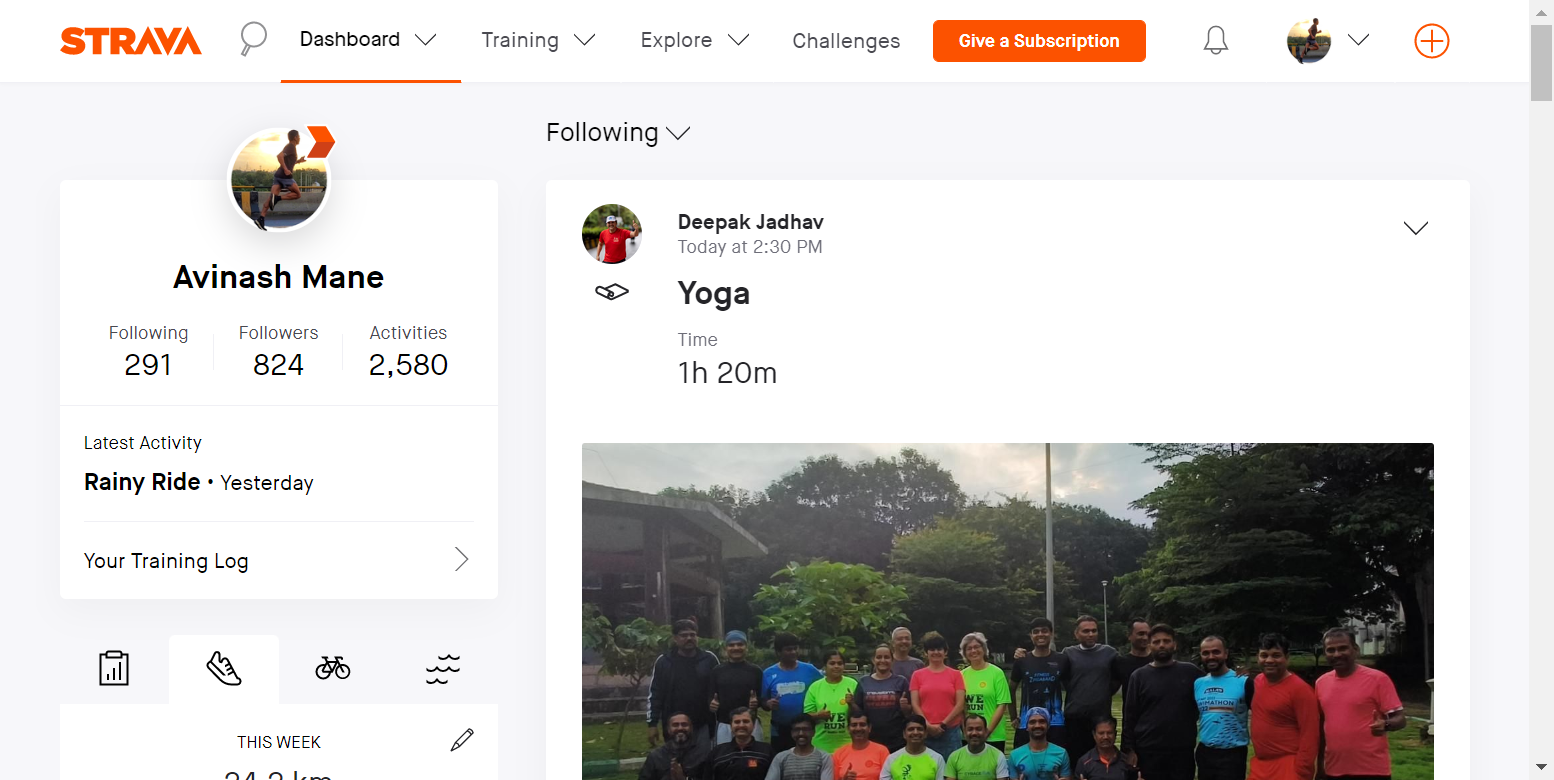

2022-10-21 15:22:38:INFO:Total number of cards on avinash/Dashboard | Strava: 39


2022-10-21 15:22:44:INFO:Stats: {'tot_kudos': 2, 'kudos': 2, 'NoLoc': 2}


###  avinash https://www.strava.com/clubs/delhirunnersgroup Club Likes

2022-10-21 15:22:50:INFO:Total number of cards on https://www.strava.com/clubs/delhirunnersgroup 'New Delhi, Delhi, India Club | DRG Delhi Runners Group on Strava': 20


2022-10-21 15:23:03:INFO:Stats: {'tot_kudos': 4, 'kudos': 4, 'NoLoc': 4}
2022-10-21 15:23:09:INFO:Logged out


### mileage_league_strava Feed Likes

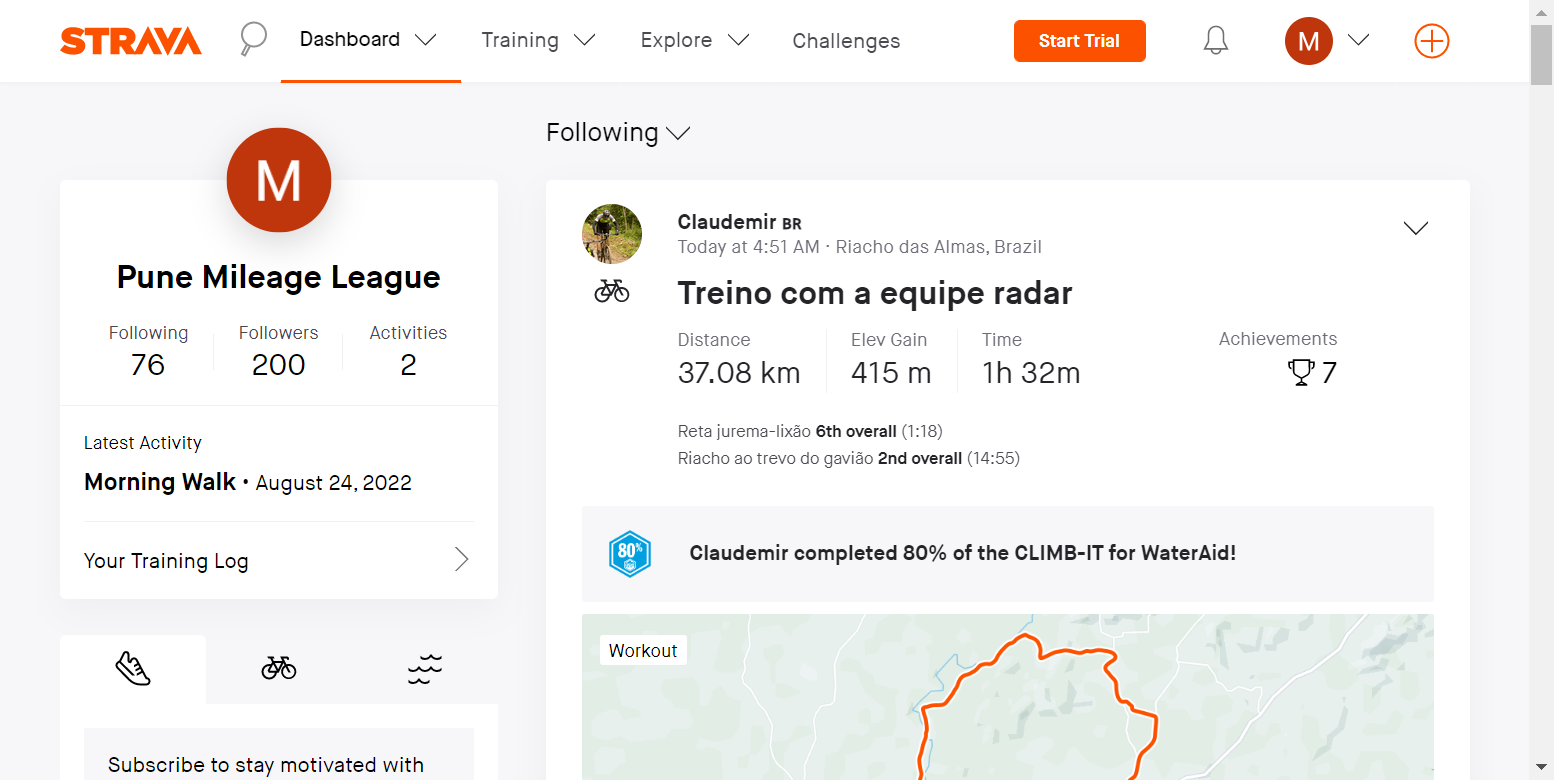

2022-10-21 15:23:30:INFO:Total number of cards on mileage_league_strava/Dashboard | Strava: 39


2022-10-21 15:23:40:INFO:Stats: {'tot_kudos': 4, 'kudos': 4, 'NoLoc': 4}


###  mileage_league_strava https://www.strava.com/clubs/mileageleague Club Likes

2022-10-21 15:23:46:INFO:Total number of cards on https://www.strava.com/clubs/mileageleague 'Atlanta, Georgia Club | Mileage League: 2022 in 2022 on Strava': 20
2022-10-21 15:23:46:INFO:Stats: {'tot_kudos': 0, 'kudos': 0}


###  mileage_league_strava https://www.strava.com/clubs/pcmcrunners Club Likes

2022-10-21 15:23:51:INFO:Total number of cards on https://www.strava.com/clubs/pcmcrunners 'Pimpri-Chinchwad, Maharashtra, India Club | PCMCRunners on Strava': 20


2022-10-21 15:23:56:INFO:Stats: {'tot_kudos': 2, 'kudos': 2, 'NoLoc': 2}


###  mileage_league_strava https://www.strava.com/clubs/prettycoolmileagechallenge Club Likes

2022-10-21 15:24:02:INFO:Total number of cards on https://www.strava.com/clubs/prettycoolmileagechallenge 'India Club | Milage Challenge : 2022 in 2022 on Strava': 20
2022-10-21 15:24:02:INFO:Stats: {'tot_kudos': 0, 'kudos': 0}


###  mileage_league_strava https://www.strava.com/clubs/pcmcbikers Club Likes

2022-10-21 15:24:08:INFO:Total number of cards on https://www.strava.com/clubs/pcmcbikers 'Pimpri-Chinchwad, Maharashtra, India Club | PCMC Tring Tring on Strava': 20
2022-10-21 15:24:08:INFO:Stats: {'tot_kudos': 0, 'kudos': 0}


###  mileage_league_strava https://www.strava.com/clubs/punecycling Club Likes

2022-10-21 15:24:14:INFO:Total number of cards on https://www.strava.com/clubs/punecycling 'Pune, Maharashtra, India Club | Strava Pune Cycling on Strava': 20


calling... https://www.strava.com/activities/7996031579


2022-10-21 15:24:27:INFO:Posting message [73.6, 18.8],{'start_xy': 'POINT (73.81901881657541 18.61826939508319)', 'avg_speed': None, 'avg_heartrate': None, 'has_heartrate': False},[74, 18.4],Well done! 
Consistency wins over speed for athletes with long-term fitness goal.  You are cordially invited to join club https://www.strava.com/clubs/punemileageleague for additional motivation and leaderboards of like-minded athletes.
 
2022-10-21 15:24:27:WARNING:Error in giveKudoComment(): TypeError('expected string or bytes-like object')


Traceback (most recent call last):
  File "lib\socialmediasite.py", line 284, in giveKudoComment
    commentEl=self.browser.button(data_testid=re.compile("comment_button|open_comment_modal_button")).wait_until(method=lambda x:x.exists)
  File "c:\sw\python37\lib\site-packages\nerodia\wait\wait.py", line 111, in wait_until
    object=object)
  File "c:\sw\python37\lib\site-packages\nerodia\wait\wait.py", line 33, in until
    result = cls._run_with_timer(timeout, interval, method, object, until=True)
  File "c:\sw\python37\lib\site-packages\nerodia\wait\wait.py", line 78, in _run_with_timer
    object=object, expected=until)
  File "c:\sw\python37\lib\site-packages\nerodia\wait\timer.py", line 25, in wait
    result = method(object) if object else method()
  File "c:\sw\python37\lib\site-packages\nerodia\wait\wait.py", line 197, in func
    return (not obj or self._match_attributes(obj, until)()) and (not method or method(*args))
  File "lib\socialmediasite.py", line 284, in <lambda>
  

2022-10-21 15:24:42:INFO:Stats: {'tot_kudos': 7, 'kudos': 7, 'NoLoc': 6, 'Errorexpected string or bytes-like object': 1}


###  mileage_league_strava https://www.strava.com/clubs/didyouruntoday Club Likes

2022-10-21 15:24:47:INFO:Total number of cards on https://www.strava.com/clubs/didyouruntoday 'Mumbai, Maharashtra, India Club | Did you run today on Strava': 20


2022-10-21 15:24:50:INFO:Stats: {'tot_kudos': 1, 'kudos': 1, 'NoLoc': 1}


###  mileage_league_strava https://www.strava.com/clubs/PuneWalkers Club Likes

2022-10-21 15:24:56:INFO:Total number of cards on https://www.strava.com/clubs/PuneWalkers 'Pune, Maharashtra, India Club | Pune Walkers on Strava': 20
2022-10-21 15:24:56:INFO:Stats: {'tot_kudos': 0, 'kudos': 0}


###  mileage_league_strava https://www.strava.com/clubs/prettycoolmileagechallenge Club Likes

2022-10-21 15:25:02:INFO:Total number of cards on https://www.strava.com/clubs/prettycoolmileagechallenge 'India Club | Milage Challenge : 2022 in 2022 on Strava': 20
2022-10-21 15:25:02:INFO:Stats: {'tot_kudos': 0, 'kudos': 0}


###  mileage_league_strava https://www.strava.com/clubs/mileageleague Club Likes

2022-10-21 15:25:08:INFO:Total number of cards on https://www.strava.com/clubs/mileageleague 'Atlanta, Georgia Club | Mileage League: 2022 in 2022 on Strava': 20
2022-10-21 15:25:08:INFO:Stats: {'tot_kudos': 0, 'kudos': 0}


###  mileage_league_strava https://www.strava.com/clubs/weekendriderspune Club Likes

KeyboardInterrupt: 

In [10]:
for _user,_config in {
                    "avinash":"avinash",
                    "mileage_league_strava":"mileage_league_strava",
                    # "strava_pcmcrunners":"strava_pcmcrunners"
                    }.items():
    display(Markdown(f"### {_user} Feed Likes"))
    strava.login(_user)
    strava.goto('https://www.strava.com/dashboard')
    display(Image(b.screenshot.png()))
    strava.scrolldown(4) 
    _cards=len(b.divs(class_name=re.compile('^Card')))
    logging.info(f"Total number of cards on {_user}/{strava.browser.title}: {_cards}")
    ret=strava.giveKudos()
    logging.info(f"Stats: {ret!r}")
    #SessionLog :   Date	SessionType	User	Feed	cards	actions
    sessionGSheet.append_table([[pd.Timestamp.now().isoformat(),"Kudos",_user,'feed',_cards,ret['tot_kudos']]])
    
    for club in strava.cfg['strava'][_config]['clubs']:
      display(Markdown(f"###  {_user} {club} Club Likes"))
      strava.goto(f"{club}/recent_activity")
      _cards=len(b.divs(class_name=re.compile('^Card')))
      logging.info(f"Total number of cards on {club} '{strava.browser.title}': {_cards}")
      ret=strava.giveKudos()
      logging.info(f"Stats: {ret!r}")
      #SessionLog :   Date	SessionType	User	Feed	cards	actions
      sessionGSheet.append_table([[pd.Timestamp.now().isoformat(),"Kudos",_user,club,_cards,ret['tot_kudos']]])
        
    strava.logout()
    
logging.info(f"All Groups done")    

# Archive Logs

In [ ]:
MIN_ROWS_TO_ARCHIVE=2000

if os.name=='posix':
    for sh in promoSheet.ws.worksheets():
      print(sh.title,sh.rows,sh.cols,sh.rows*sh.cols,'cells')
    
      if 'StravaPromoLog' in sh.title:
        df=sh.get_as_df()
        
        if len(df) > MIN_ROWS_TO_ARCHIVE:
          df.to_csv(f"{DATA}/{fileName}")

          fileName=f"{sh.title.replace(' ','_')}_{pd.Timestamp.now().isoformat()[:13]}.csv"
          logging.info(f"Saving to {fileName}")

          sh.delete_cols(len(df.columns)+1,
                         number=sh.rows-len(df.columns)-1)
          sh.delete_rows(2, number=len(df))
          logging.info(f'Cleared tab {sh.title}')

# test

In [ ]:
# {x.text[:30]:x.link().href for x in b.divs(data_testid="activity_entry_container")}

In [11]:
# del strava,Strava
if True:
    %env COUNTER_PROMO_COMMENT 0
    
    importlib.reload(socialmediasite)
    strava=socialmediasite.Strava(b,                                      #authFile=f'{AUTH}/auth.yaml',
                  cfg=cfg,
                  delay=.5)
    df_mc=gsheets.Gsheet(cfg['sheets']['stravasync']['url'],service_account_file=service_account_file
                        ).getSheetDf(cfg['sheets']['stravasync']['tab'],start='A10')
   
    strava.logGSheet = gsheets.Gsheet(cfg['sheets']['StravaPromoLog']['url'],
                             service_account_file=service_account_file
                             ).getSheetByTitle('StravaPromoLog') 
    strava.promoCommentLog = gsheets.Gsheet(cfg['sheets']['StravaPromoLog']['url'],
                                   service_account_file=service_account_file
                                   ).getSheetByTitle('PromoCommentLog')
    strava.promoCommentedIds=list(strava.promoCommentLog.get_as_df().id.values)
    strava.StravaMembers=df_mc.query('strava=="strava"').id.values
    sessionGSheet = Gsheet(cfg['sheets']['StravaPromoLog']['url'],service_account_file=service_account_file
                          ).getSheetByTitle('SessionLog')
    ##
    for user in ["mileage_league_strava"]:
        strava.login(user)
        for club in strava.cfg['strava'][user]['clubs']:
            display(Markdown(f"###  {user} {club} Club Likes"))
            strava.goto(f"{club}/recent_activity")

            # strava.scrolldown(4)

            for i,kudoTag in enumerate(b.buttons({'data_testid':'kudos_button'})):
                actEl=kudoTag.parent(class_name='Card--feed-entry--eeHS5')
                # print(i,actEl.text[:30].replace('\n','|'))
                if True:
                  # self=strava
                  ath,athUrl,loc,act,actUrl,kudoCount=strava.getPostData(actEl)

                  athId,athIdCat=strava._getAthIdCat(athUrl)
                  print('>',athId,ath,actUrl,loc, 
                        strava.checkPromoComment(athId,athIdCat,athUrl,ath,actUrl,loc))
                    # self.printKudos(i,athIdCat,ath,athUrl,loc,act,actUrl,kudoCount,promoSuccess)



env: COUNTER_PROMO_COMMENT=0


###  mileage_league_strava https://www.strava.com/clubs/mileageleague Club Likes

> 96424784 Bhushan Vishwanath https://www.strava.com/activities/7995457664 None NoLoc
> 35809161 Sundarakannan Annadurai https://www.strava.com/activities/7995208297  · Hyderabad, Telangana NoLoc
> 31702944 Rohit Shetty | RD https://www.strava.com/activities/7995878299  · Mulshi, Maharashtra Member
> 31702944 Rohit Shetty | RD https://www.strava.com/activities/7995878038  · Mulshi, Maharashtra Member
> 61564254 Manoj A Patiil 🇮🇳 https://www.strava.com/activities/7992831128 None NoLoc
> 10934375 Avinash Mane https://www.strava.com/activities/7991975383  · Mulshi, Maharashtra Member
> 10934375 Avinash Mane https://www.strava.com/activities/7990815355  · Mulshi, Maharashtra Member
> 35809161 Sundarakannan Annadurai https://www.strava.com/activities/7990562580  · Hyderabad, Telangana NoLoc
> 31702944 Rohit Shetty | RD https://www.strava.com/activities/7990597175  · Mulshi, Maharashtra Member
> 31702944 Rohit Shetty | RD https://www.strava.com/activities/7990597072  · Mulshi, Maharashtra Me

2022-10-21 15:26:47:INFO:Posting message [73.6, 18.8],{'start_xy': 'POINT (73.83765497244895 18.542714919894934)', 'avg_speed': None, 'avg_heartrate': None, 'has_heartrate': False},[74, 18.4],Well done! 
Consistency wins over speed for athletes with long-term fitness goal.  You are cordially invited to join club https://www.strava.com/clubs/punemileageleague for additional motivation and leaderboards of like-minded athletes.
 


> 68869718 Swapnil Adkar https://www.strava.com/activities/7980261983  · Pune City, Maharashtra Post draft
> 31702944 Rohit Shetty | RD https://www.strava.com/activities/7980164495  · Mulshi, Maharashtra Member
> 35809161 Sundarakannan Annadurai https://www.strava.com/activities/7980070450  · Hyderabad, Telangana NoLoc


###  mileage_league_strava https://www.strava.com/clubs/pcmcrunners Club Likes

> 44810319 Ag Rezuan https://www.strava.com/activities/7996059370  · Kuala Lumpur, Malaysia NoLoc
> 24968958 Pankaj Ravalu | ARHATA | ACC https://www.strava.com/activities/7996012319  · Kolhapur, Maharashtra NoLoc
> 35479129 Jack Fan https://www.strava.com/activities/7995790715 None NoLoc
> 60436252 Mohamed Ismail https://www.strava.com/activities/7995747123  · Cairo, Egypt NoLoc
> 47553513 Ahmed Raafat https://www.strava.com/activities/7995678562  · Giza, Egypt NoLoc
> 21472061 Sandeep Pardeshi (Solo Rider)🚴‍♀️🏃🚶🇮🇳 https://www.strava.com/activities/7995581247 None NoLoc
> 43245708 Sadanand Padmawar🏃🏻🚴 https://www.strava.com/activities/7995510210 None NoLoc
> 49734608 Anil Dash🇮🇳 https://www.strava.com/activities/7995554050 None NoLoc
> 33114091 pradip wandhekar https://www.strava.com/activities/7995423393 None NoLoc
> 4012321 Vivek Bhargava https://www.strava.com/activities/7995422196 None NoLoc
calling... https://www.strava.com/activities/7995430813


2022-10-21 15:27:02:INFO:Posting message [73.6, 18.8],{'start_xy': 'POINT (73.76743172295392 18.60261669382453)', 'avg_speed': None, 'avg_heartrate': None, 'has_heartrate': True},[74, 18.4],Well done! 
Consistency wins over speed for athletes with long-term fitness goal.  You are cordially invited to join club https://www.strava.com/clubs/punemileageleague for additional motivation and leaderboards of like-minded athletes.
 


> 63948277 Ironman Pandurang Bodke https://www.strava.com/activities/7995430813  · Mulshi, Maharashtra Post draft
> 16630250 Om Katthar https://www.strava.com/activities/7995410880  · Mulshi, Maharashtra Member
> 48352644 Rakesh Arya https://www.strava.com/activities/7995389660 None NoLoc
calling... https://www.strava.com/activities/7995386934


2022-10-21 15:27:10:INFO:Posting message [73.6, 18.8],{'start_xy': 'POINT (73.8856503367424 18.541591493412852)', 'avg_speed': None, 'avg_heartrate': None, 'has_heartrate': False},[74, 18.4],Well done! 
Consistency wins over speed for athletes with long-term fitness goal.  You are cordially invited to join club https://www.strava.com/clubs/punemileageleague for additional motivation and leaderboards of like-minded athletes.
 


> 72972595 Balasaheb Aher https://www.strava.com/activities/7995386934  · Pune City, Maharashtra Post draft
calling... https://www.strava.com/activities/7995530109


2022-10-21 15:27:17:INFO:Posting message [73.6, 18.8],{'start_xy': 'POINT (73.781115 18.59327333)', 'avg_speed': None, 'avg_heartrate': None, 'has_heartrate': True},[74, 18.4],Well done! 
Consistency wins over speed for athletes with long-term fitness goal.  You are cordially invited to join club https://www.strava.com/clubs/punemileageleague for additional motivation and leaderboards of like-minded athletes.
 


> 94005048 Devesh B https://www.strava.com/activities/7995530109  · Haveli, Maharashtra Post draft
> 28667962 MADHUKAR THORAT https://www.strava.com/activities/7995808324  · Mawal, Maharashtra NoLoc
> 31590333 Subodh Bhagat 🇮🇳 https://www.strava.com/activities/7995361280  · Garudeshwar Taluka, Gujarat NoLoc
calling... https://www.strava.com/activities/7995356314


2022-10-21 15:27:24:INFO:Posting message [73.6, 18.8],{'start_xy': 'POINT (73.79511639475822 18.571933060884476)', 'avg_speed': None, 'avg_heartrate': None, 'has_heartrate': False},[74, 18.4],Well done! 
Consistency wins over speed for athletes with long-term fitness goal.  You are cordially invited to join club https://www.strava.com/clubs/punemileageleague for additional motivation and leaderboards of like-minded athletes.
 


> 70042060 Harshal. K https://www.strava.com/activities/7995356314  · Haveli, Maharashtra Post draft
> 89879331 Sneha Subramaniam https://www.strava.com/activities/7995356855 None NoLoc
calling... https://www.strava.com/activities/7995350616


2022-10-21 15:27:30:INFO:Posting message [73.6, 18.8],{'start_xy': 'POINT (73.77439415082335 18.594219284132123)', 'avg_speed': None, 'avg_heartrate': None, 'has_heartrate': True},[74, 18.4],Well done! 
Consistency wins over speed for athletes with long-term fitness goal.  You are cordially invited to join club https://www.strava.com/clubs/punemileageleague for additional motivation and leaderboards of like-minded athletes.
 


> 100146852 Pritam Bhavsar https://www.strava.com/activities/7995350616  · Mulshi, Maharashtra Post draft


###  mileage_league_strava https://www.strava.com/clubs/prettycoolmileagechallenge Club Likes

> 8542102 Kamal Tilani https://www.strava.com/activities/7995667880 None NoLoc
> 66266609 Irfan Khan 🇮🇳 https://www.strava.com/activities/7995417408 None NoLoc
> 49879981 Nilesh Kurmi 🥰😍🤗 🇮🇳🇮🇳🇮🇳 https://www.strava.com/activities/7995272875  · Haveli, Maharashtra Member
> 36256576 Sudeep Srivastav https://www.strava.com/activities/7995258802  · Sadar, Uttar Pradesh NoLoc
calling... https://www.strava.com/activities/7995180817


2022-10-21 15:27:43:INFO:Posting message [73.6, 18.8],{'start_xy': 'POINT (73.79076333716512 18.593407832086086)', 'avg_speed': None, 'avg_heartrate': None, 'has_heartrate': False},[74, 18.4],Well done! 
Consistency wins over speed for athletes with long-term fitness goal.  You are cordially invited to join club https://www.strava.com/clubs/punemileageleague for additional motivation and leaderboards of like-minded athletes.
 


> 66266609 Irfan Khan 🇮🇳 https://www.strava.com/activities/7995180817  · Haveli, Maharashtra Post draft
> 32933819 Navnath Rodage https://www.strava.com/activities/7995136507  · Karmala, Maharashtra NoLoc
> 32038544 Randhir Padwal 🏊‍♂️ 🚴🏻‍♂️ 🏃🏻‍♂️ 🇮🇳 https://www.strava.com/activities/7995605633 None NoLoc
calling... https://www.strava.com/activities/7995142108


2022-10-21 15:27:50:INFO:Posting message [73.6, 18.8],{'start_xy': 'POINT (73.77907494083047 18.544849203899503)', 'avg_speed': None, 'avg_heartrate': None, 'has_heartrate': True},[74, 18.4],Well done! 
Consistency wins over speed for athletes with long-term fitness goal.  You are cordially invited to join club https://www.strava.com/clubs/punemileageleague for additional motivation and leaderboards of like-minded athletes.
 


> 56727421 Bhika Chaudhari https://www.strava.com/activities/7995142108  · Pune City, Maharashtra Post draft
> 32038544 Randhir Padwal 🏊‍♂️ 🚴🏻‍♂️ 🏃🏻‍♂️ 🇮🇳 https://www.strava.com/activities/7993168122 None NoLoc
> 10934375 Avinash Mane https://www.strava.com/activities/7991975383  · Mulshi, Maharashtra Member
> 10934375 Avinash Mane https://www.strava.com/activities/7990815355  · Mulshi, Maharashtra Member
> 8542102 Kamal Tilani https://www.strava.com/activities/7990743845  · Haveli, Maharashtra Member
> 8542102 Kamal Tilani https://www.strava.com/activities/7990670631  · Haveli, Maharashtra Member
> 8542102 Kamal Tilani https://www.strava.com/activities/7990670108 None NoLoc
> 8542102 Kamal Tilani https://www.strava.com/activities/7990597635  · Haveli, Maharashtra Member
> 8542102 Kamal Tilani https://www.strava.com/activities/7990558802  · Haveli, Maharashtra Member
> 49879981 Nilesh Kurmi 🥰😍🤗 🇮🇳🇮🇳🇮🇳 https://www.strava.com/activities/7990559336  · Haveli, Maharashtra Member
calling...

2022-10-21 15:27:59:INFO:Posting message [73.6, 18.8],{'start_xy': 'POINT (73.79660259000957 18.59233008697629)', 'avg_speed': None, 'avg_heartrate': None, 'has_heartrate': False},[74, 18.4],Well done! 
Consistency wins over speed for athletes with long-term fitness goal.  You are cordially invited to join club https://www.strava.com/clubs/punemileageleague for additional motivation and leaderboards of like-minded athletes.
 


> 19973469 Ganesh Dhamagunde https://www.strava.com/activities/7990450294  · Haveli, Maharashtra Post draft
> 56727421 Bhika Chaudhari https://www.strava.com/activities/7990473204  · Pune City, Maharashtra prev
> 49879981 Nilesh Kurmi 🥰😍🤗 🇮🇳🇮🇳🇮🇳 https://www.strava.com/activities/7994141022  · Haveli, Maharashtra Member


###  mileage_league_strava https://www.strava.com/clubs/pcmcbikers Club Likes

> 54729570 Claudemir 🇧🇷 https://www.strava.com/activities/7996079117  · Riacho das Almas, Brazil NoLoc
> 5480072 Ivan Shevchenko https://www.strava.com/activities/7995795865  · Basarabeasca District, Moldova NoLoc
> 65788924 Lou Matulac 💯♂️🍀🌴 https://www.strava.com/activities/7995793251 None NoLoc
calling... https://www.strava.com/activities/7995734360


2022-10-21 15:28:12:INFO:Posting message [73.6, 18.8],{'start_xy': 'POINT (73.8872722350061 18.66309816017747)', 'avg_speed': None, 'avg_heartrate': None, 'has_heartrate': False},[74, 18.4],Well done! 
Consistency wins over speed for athletes with long-term fitness goal.  You are cordially invited to join club https://www.strava.com/clubs/punemileageleague for additional motivation and leaderboards of like-minded athletes.
 


> 48012024 Vishal Kolhe https://www.strava.com/activities/7995734360  · Haveli, Maharashtra Post draft
> 102209102 Ramdas Raje Pawar🇮🇳 https://www.strava.com/activities/7995713111  · Mawal, Maharashtra NoLoc
> 8542102 Kamal Tilani https://www.strava.com/activities/7995667880 None NoLoc
> 46875595 Hamad Alghafrani https://www.strava.com/activities/7995585667  · Doha, Qatar NoLoc
> 18049055 mohamed alkhulaifi https://www.strava.com/activities/7995542292  · Al Daayen, Qatar NoLoc
calling... https://www.strava.com/activities/7995423780


2022-10-21 15:28:26:INFO:Posting message [73.6, 18.8],{'start_xy': 'POINT (73.78397986292839 18.62147773616016)', 'avg_speed': None, 'avg_heartrate': None, 'has_heartrate': True},[74, 18.4],Well done! 
Consistency wins over speed for athletes with long-term fitness goal.  You are cordially invited to join club https://www.strava.com/clubs/punemileageleague for additional motivation and leaderboards of like-minded athletes.
 


> 26622310 IRONMAN RAHUL NALAWADE ECO 🚴🏊🏃 https://www.strava.com/activities/7995423780  · Haveli, Maharashtra Post draft
> 18049055 mohamed alkhulaifi https://www.strava.com/activities/7995541523  · Al Daayen, Qatar NoLoc
calling... https://www.strava.com/activities/7995398922


2022-10-21 15:28:40:INFO:Posting message [73.6, 18.8],{'start_xy': 'POINT (73.81490363739431 18.591420063748956)', 'avg_speed': None, 'avg_heartrate': None, 'has_heartrate': False},[74, 18.4],Well done! 
Consistency wins over speed for athletes with long-term fitness goal.  You are cordially invited to join club https://www.strava.com/clubs/punemileageleague for additional motivation and leaderboards of like-minded athletes.
 


> 62661401 Dr Deepak Gajare https://www.strava.com/activities/7995398922  · Haveli, Maharashtra Post draft
calling... https://www.strava.com/activities/7995399219


2022-10-21 15:28:48:INFO:Posting message [73.6, 18.8],{'start_xy': 'POINT (73.74965412542224 18.555447785183787)', 'avg_speed': None, 'avg_heartrate': None, 'has_heartrate': False},[74, 18.4],Well done! 
Consistency wins over speed for athletes with long-term fitness goal.  You are cordially invited to join club https://www.strava.com/clubs/punemileageleague for additional motivation and leaderboards of like-minded athletes.
 


> 29383022 Sandeep Gandekar 9881735870 https://www.strava.com/activities/7995399219  · Mulshi, Maharashtra Post draft
calling... https://www.strava.com/activities/7995414250


2022-10-21 15:28:55:INFO:Posting message [73.6, 18.8],{'start_xy': 'POINT (73.801956 18.6356)', 'avg_speed': None, 'avg_heartrate': None, 'has_heartrate': True},[74, 18.4],Well done! 
Consistency wins over speed for athletes with long-term fitness goal.  You are cordially invited to join club https://www.strava.com/clubs/punemileageleague for additional motivation and leaderboards of like-minded athletes.
 


> 26473630 TONI RAMCHANDANI https://www.strava.com/activities/7995414250  · Haveli, Maharashtra Post draft
> 65788924 Lou Matulac 💯♂️🍀🌴 https://www.strava.com/activities/7995371001 None NoLoc
> 73018171 Rajeshwar Khajone - Bari https://www.strava.com/activities/7995306606  · Nashik, Maharashtra NoLoc
> 39950549 Dr Vijay Kolli https://www.strava.com/activities/7995288263  · Guntur, Andhra Pradesh NoLoc
> 16135322 Charanjit S. Rehal https://www.strava.com/activities/7995250645  · Bathinda Tahsil, Punjab NoLoc
> 48254265 Pradeep Raigad ,Maharashtra,INDIA https://www.strava.com/activities/7995246774  · Mumbai Metropolitan Region, Maharashtra NoLoc
> 41338476 Biradar Gangadhar 🇮🇳🇮🇳🚲🚲 https://www.strava.com/activities/7995242627  · Latur, Maharashtra NoLoc
> 76224768 Mayur Jsk https://www.strava.com/activities/7995346773  · Rajkot Taluka, Gujarat NoLoc


###  mileage_league_strava https://www.strava.com/clubs/punecycling Club Likes

> 19993862 Leo Vegan 🌱 https://www.strava.com/activities/7996120712  · Rio de Janeiro, Brazil NoLoc
> 92268913 Harish Kumar https://www.strava.com/activities/7996068706  · Bengaluru, Karnataka NoLoc
> 46771978 Jtorres 🛩️🚴🏓🇧🇷 https://www.strava.com/activities/7996045438  · Patos, Brazil NoLoc
calling... https://www.strava.com/activities/7996031579


2022-10-21 15:29:11:INFO:Posting message [73.6, 18.8],{'start_xy': 'POINT (73.81901881657541 18.61826939508319)', 'avg_speed': None, 'avg_heartrate': None, 'has_heartrate': False},[74, 18.4],Well done! 
Consistency wins over speed for athletes with long-term fitness goal.  You are cordially invited to join club https://www.strava.com/clubs/punemileageleague for additional motivation and leaderboards of like-minded athletes.
 


> 2639435 Aamir Shaikh 🇮🇳 🚴 https://www.strava.com/activities/7996031579  · Haveli, Maharashtra Post draft
> 33788704 Derek Ching https://www.strava.com/activities/7996023173 None NoLoc
> 72366664 Tiago Brazil🇧🇷 https://www.strava.com/activities/7996088183  · São Paulo, Brazil NoLoc
> 63871322 Fabian Villiger https://www.strava.com/activities/7995979386  · Rio de Janeiro, Brazil NoLoc
> 69088712 raj bharadwaj https://www.strava.com/activities/7995938231  · Northeast, Singapore NoLoc
> 29264902 Kyong Ho Mun https://www.strava.com/activities/7995895551  · Hansol-dong, South Korea NoLoc
> 24715282 N, J, Park https://www.strava.com/activities/7995884439  · Nam-gu, South Korea NoLoc
calling... https://www.strava.com/activities/7995881544


2022-10-21 15:29:20:INFO:Posting message [73.6, 18.8],{'start_xy': 'POINT (73.938799 18.530027)', 'avg_speed': None, 'avg_heartrate': None, 'has_heartrate': True},[74, 18.4],Well done! 
Consistency wins over speed for athletes with long-term fitness goal.  You are cordially invited to join club https://www.strava.com/clubs/punemileageleague for additional motivation and leaderboards of like-minded athletes.
 


> 71753828 Akshay Bakre https://www.strava.com/activities/7995881544  · Pune City, Maharashtra Post draft
> 7163380 Michael Clayton https://www.strava.com/activities/7995870889 None NoLoc
> 19952822 Sanjay Chhabada https://www.strava.com/activities/7995796389 None NoLoc
> 5480072 Ivan Shevchenko https://www.strava.com/activities/7995795865  · Basarabeasca District, Moldova NoLoc
> 503858 Ahmad Ismaeel © ® 🇪🇬 https://www.strava.com/activities/7995826767  · Cairo, Egypt NoLoc
> 48012024 Vishal Kolhe https://www.strava.com/activities/7995734360  · Haveli, Maharashtra prev
> 5609488 Sam Burns #trinirvana https://www.strava.com/activities/7995721169  · Surat Thani Province, Thailand NoLoc
> 2639435 Aamir Shaikh 🇮🇳 🚴 https://www.strava.com/activities/7995679733  · Haveli, Maharashtra prev
> 8542102 Kamal Tilani https://www.strava.com/activities/7995667880 None NoLoc
calling... https://www.strava.com/activities/7995641766


2022-10-21 15:29:30:INFO:Posting message [73.6, 18.8],{'start_xy': 'POINT (73.81989514455199 18.468449749052525)', 'avg_speed': None, 'avg_heartrate': None, 'has_heartrate': False},[74, 18.4],Well done! 
Consistency wins over speed for athletes with long-term fitness goal.  You are cordially invited to join club https://www.strava.com/clubs/punemileageleague for additional motivation and leaderboards of like-minded athletes.
 


> 74167839 Shreyas Patil https://www.strava.com/activities/7995641766  · Pune City, Maharashtra Post draft


###  mileage_league_strava https://www.strava.com/clubs/didyouruntoday Club Likes

> 13602899 Fernando🇪🇸🇪🇸(@nando_runer) Istg :nando_runer https://www.strava.com/activities/7996047896  · Ubrique, Spain NoLoc
> 40415203 Philbert Alfred 👊 https://www.strava.com/activities/7995984727 None NoLoc
> 23547880 Karzan Qazaq https://www.strava.com/activities/7995728340  · Tehran, Iran NoLoc
> 32513456 Maria Running 🇬🇷🏃‍♀️🌞 https://www.strava.com/activities/7995683684  · Municipality of Athens, Greece NoLoc
> 23247107 Agamemnon Roumeliotis https://www.strava.com/activities/7995672952 None NoLoc
> 13825240 Alberto Cerlini https://www.strava.com/activities/7995505725  · Turin, Italy NoLoc
> 30211938 Victor Lebohang Nyamate Thwala https://www.strava.com/activities/7995711575  · City of Johannesburg Metropolitan Municipality, RSA NoLoc
> 4012321 Vivek Bhargava https://www.strava.com/activities/7995422196 None NoLoc
> 46048380 Andrew Owen https://www.strava.com/activities/7995398959  · Carmarthenshire, United Kingdom NoLoc
> 35559460 Mwendwa Koki https://www.strava.com/activities/79

###  mileage_league_strava https://www.strava.com/clubs/PuneWalkers Club Likes

> 41030676 Ahmed Yassien https://www.strava.com/activities/7995625192  · Alexandria, Egypt NoLoc
calling... https://www.strava.com/activities/7995378522


2022-10-21 15:29:58:INFO:Posting message [73.6, 18.8],{'start_xy': 'POINT (73.90682302415371 18.509526774287224)', 'avg_speed': None, 'avg_heartrate': None, 'has_heartrate': True},[74, 18.4],Well done! 
Consistency wins over speed for athletes with long-term fitness goal.  You are cordially invited to join club https://www.strava.com/clubs/punemileageleague for additional motivation and leaderboards of like-minded athletes.
 


> 27861517 Supriya Shitole https://www.strava.com/activities/7995378522  · Pune City, Maharashtra Post draft
> 98304806 Mohammad Azam https://www.strava.com/activities/7995271278  · Sambhal, Uttar Pradesh NoLoc
> 26023035 Santosh Giranje https://www.strava.com/activities/7995227758 None NoLoc
> 26204746 Saurabh Maheshwari🚴🏻‍♂️🏃‍♂️🇮🇳 https://www.strava.com/activities/7995224335  · Kanpur, Uttar Pradesh NoLoc
> 35809161 Sundarakannan Annadurai https://www.strava.com/activities/7995208297  · Hyderabad, Telangana NoLoc
> 49448909 Manjusha Deshmukh https://www.strava.com/activities/7995232079  · Haveli, Maharashtra Member
calling... https://www.strava.com/activities/7995144827


2022-10-21 15:30:06:INFO:Posting message [73.6, 18.8],{'start_xy': 'POINT (73.9377168752253 18.51814739406109)', 'avg_speed': None, 'avg_heartrate': None, 'has_heartrate': False},[74, 18.4],Well done! 
Consistency wins over speed for athletes with long-term fitness goal.  You are cordially invited to join club https://www.strava.com/clubs/punemileageleague for additional motivation and leaderboards of like-minded athletes.
 


> 86706503 Unmesh Deo I RUNAHOLICS https://www.strava.com/activities/7995144827  · Haveli, Maharashtra Post draft
> 39669255 HUGO VALFRÉ https://www.strava.com/activities/7995165439  · Municipio de Embalse, Argentina NoLoc
> 99067278 Pooja Giri https://www.strava.com/activities/7995066995  · Indore Tahsil, Madhya Pradesh NoLoc
> 68531928 Ranjan Kumar🇮🇳 https://www.strava.com/activities/7995041779  · Rourkela, Odisha NoLoc
> 26622310 IRONMAN RAHUL NALAWADE ECO 🚴🏊🏃 https://www.strava.com/activities/7995080049  · Haveli, Maharashtra prev
> 30205023 Jairam Nagargoje https://www.strava.com/activities/7994906078  · Shirur, Maharashtra NoLoc
> 26633436 'Gerson Machado' 🇧🇷 https://www.strava.com/activities/7995042932  · Curitiba, Brazil NoLoc
> 37755161 Prasanna Gadkari https://www.strava.com/activities/7994754204  · Surrey, Canada NoLoc
> 65702938 Alejandro David González🌞😊🏃‍♂️🚴‍♂️🏊‍♂️ https://www.strava.com/activities/7994668375  · New Milford, USA NoLoc
> 45296734 Michael Carter, Ph.D. Cand

2022-10-21 15:30:16:INFO:Posting message [73.6, 18.8],{'start_xy': 'POINT (73.99417335167527 18.590355897322297)', 'avg_speed': None, 'avg_heartrate': None, 'has_heartrate': False},[74, 18.4],Well done! 
Consistency wins over speed for athletes with long-term fitness goal.  You are cordially invited to join club https://www.strava.com/clubs/punemileageleague for additional motivation and leaderboards of like-minded athletes.
 


> 30361620 Rakesh Prajapati https://www.strava.com/activities/7992915602  · Pune City, Maharashtra Post draft


###  mileage_league_strava https://www.strava.com/clubs/prettycoolmileagechallenge Club Likes

> 8542102 Kamal Tilani https://www.strava.com/activities/7995667880 None NoLoc
> 66266609 Irfan Khan 🇮🇳 https://www.strava.com/activities/7995417408 None NoLoc
> 49879981 Nilesh Kurmi 🥰😍🤗 🇮🇳🇮🇳🇮🇳 https://www.strava.com/activities/7995272875  · Haveli, Maharashtra Member
> 36256576 Sudeep Srivastav https://www.strava.com/activities/7995258802  · Sadar, Uttar Pradesh NoLoc
> 66266609 Irfan Khan 🇮🇳 https://www.strava.com/activities/7995180817  · Haveli, Maharashtra prev
> 32933819 Navnath Rodage https://www.strava.com/activities/7995136507  · Karmala, Maharashtra NoLoc
> 32038544 Randhir Padwal 🏊‍♂️ 🚴🏻‍♂️ 🏃🏻‍♂️ 🇮🇳 https://www.strava.com/activities/7995605633 None NoLoc
> 56727421 Bhika Chaudhari https://www.strava.com/activities/7995142108  · Pune City, Maharashtra prev
> 32038544 Randhir Padwal 🏊‍♂️ 🚴🏻‍♂️ 🏃🏻‍♂️ 🇮🇳 https://www.strava.com/activities/7993168122 None NoLoc
> 10934375 Avinash Mane https://www.strava.com/activities/7991975383  · Mulshi, Maharashtra Member
> 10934375 Avinash Man

###  mileage_league_strava https://www.strava.com/clubs/mileageleague Club Likes

> 96424784 Bhushan Vishwanath https://www.strava.com/activities/7995457664 None NoLoc
> 35809161 Sundarakannan Annadurai https://www.strava.com/activities/7995208297  · Hyderabad, Telangana NoLoc
> 31702944 Rohit Shetty | RD https://www.strava.com/activities/7995878299  · Mulshi, Maharashtra Member
> 31702944 Rohit Shetty | RD https://www.strava.com/activities/7995878038  · Mulshi, Maharashtra Member
> 61564254 Manoj A Patiil 🇮🇳 https://www.strava.com/activities/7992831128 None NoLoc
> 10934375 Avinash Mane https://www.strava.com/activities/7991975383  · Mulshi, Maharashtra Member
> 10934375 Avinash Mane https://www.strava.com/activities/7990815355  · Mulshi, Maharashtra Member
> 35809161 Sundarakannan Annadurai https://www.strava.com/activities/7990562580  · Hyderabad, Telangana NoLoc
> 31702944 Rohit Shetty | RD https://www.strava.com/activities/7990597175  · Mulshi, Maharashtra Member
> 31702944 Rohit Shetty | RD https://www.strava.com/activities/7990597072  · Mulshi, Maharashtra Me

###  mileage_league_strava https://www.strava.com/clubs/weekendriderspune Club Likes

> 19993862 Leo Vegan 🌱 https://www.strava.com/activities/7996120712  · Rio de Janeiro, Brazil NoLoc
> 45965362 Warren Coven https://www.strava.com/activities/7996099553 None NoLoc
> 45965362 Warren Coven https://www.strava.com/activities/7996104151 None NoLoc
> 95211305 Muhammad Joni https://www.strava.com/activities/7996089726  · Darul Imarah, Indonesia NoLoc
> 92268913 Harish Kumar https://www.strava.com/activities/7996068706  · Bengaluru, Karnataka NoLoc
> 26729825 Delfin // https://www.strava.com/activities/7996057376 None NoLoc
> 2639435 Aamir Shaikh 🇮🇳 🚴 https://www.strava.com/activities/7996031579  · Haveli, Maharashtra prev
> 4691191 @gus$ ... https://www.strava.com/activities/7996008784 None NoLoc
> 72366664 Tiago Brazil🇧🇷 https://www.strava.com/activities/7996088183  · São Paulo, Brazil NoLoc
calling... https://www.strava.com/activities/7996077806


2022-10-21 15:31:15:INFO:Posting message [73.6, 18.8],{'start_xy': 'POINT (73.796221 18.548682)', 'avg_speed': None, 'avg_heartrate': None, 'has_heartrate': True},[74, 18.4],Well done! 
Consistency wins over speed for athletes with long-term fitness goal.  You are cordially invited to join club https://www.strava.com/clubs/punemileageleague for additional motivation and leaderboards of like-minded athletes.
 


> 104014283 A Kapil https://www.strava.com/activities/7996077806  · Pune City, Maharashtra Post draft
> 69088712 raj bharadwaj https://www.strava.com/activities/7995938231  · Northeast, Singapore NoLoc
> 22216708 Mohammed Hassan https://www.strava.com/activities/7995941617  · New Cairo City, Egypt NoLoc
> 71753828 Akshay Bakre https://www.strava.com/activities/7995881544  · Pune City, Maharashtra prev
> 58316481 K.S. Lee https://www.strava.com/activities/7995849646  · Wonhyoro 1(il)-dong, South Korea NoLoc
> 5480072 Ivan Shevchenko https://www.strava.com/activities/7995795865  · Basarabeasca District, Moldova NoLoc
> 65788924 Lou Matulac 💯♂️🍀🌴 https://www.strava.com/activities/7995793251 None NoLoc
calling... https://www.strava.com/activities/7995756513


2022-10-21 15:31:24:INFO:Posting message [73.6, 18.8],{'start_xy': 'POINT (73.87578525580466 18.50236712023616)', 'avg_speed': None, 'avg_heartrate': None, 'has_heartrate': False},[74, 18.4],Well done! 
Consistency wins over speed for athletes with long-term fitness goal.  You are cordially invited to join club https://www.strava.com/clubs/punemileageleague for additional motivation and leaderboards of like-minded athletes.
 


> 109290276 Nabeel Shaikh https://www.strava.com/activities/7995756513  · Pune City, Maharashtra Post draft
> 48012024 Vishal Kolhe https://www.strava.com/activities/7995734360  · Haveli, Maharashtra prev
> 2639435 Aamir Shaikh 🇮🇳 🚴 https://www.strava.com/activities/7995679733  · Haveli, Maharashtra prev
> 90405594 NeonRider Venu@(Venu Bandi) https://www.strava.com/activities/7995656460  · Ozhukarai Taluk, Puducherry NoLoc


###  mileage_league_strava https://www.strava.com/clubs/cycleforpune Club Likes

> 95211305 Muhammad Joni https://www.strava.com/activities/7996089726  · Darul Imarah, Indonesia NoLoc
> 92268913 Harish Kumar https://www.strava.com/activities/7996068706  · Bengaluru, Karnataka NoLoc
> 70086140 Sarah Dekat https://www.strava.com/activities/7996052345 None NoLoc
calling... https://www.strava.com/activities/7996046711


2022-10-21 15:31:39:INFO:Posting message [73.6, 18.8],{'start_xy': 'POINT (73.90893945470452 18.609274523332715)', 'avg_speed': None, 'avg_heartrate': None, 'has_heartrate': True},[74, 18.4],Well done! 
Consistency wins over speed for athletes with long-term fitness goal.  You are cordially invited to join club https://www.strava.com/clubs/punemileageleague for additional motivation and leaderboards of like-minded athletes.
 


> 28322336 Vaibhav Khandale https://www.strava.com/activities/7996046711  · Haveli, Maharashtra Post draft
> 2639435 Aamir Shaikh 🇮🇳 🚴 https://www.strava.com/activities/7996031579  · Haveli, Maharashtra prev
> 74143662 antonio di pietro https://www.strava.com/activities/7996021933  · Teramo, Italy NoLoc
> 104207783 Shaimaa Amin https://www.strava.com/activities/7996024887 None NoLoc
> 4691191 @gus$ ... https://www.strava.com/activities/7996008784 None NoLoc
> 72366664 Tiago Brazil🇧🇷 https://www.strava.com/activities/7996088183  · São Paulo, Brazil NoLoc
> 104014283 A Kapil https://www.strava.com/activities/7996077806  · Pune City, Maharashtra prev
calling... https://www.strava.com/activities/7995952699


2022-10-21 15:31:49:INFO:Posting message [73.6, 18.8],{'start_xy': 'POINT (73.854608 18.465286)', 'avg_speed': None, 'avg_heartrate': None, 'has_heartrate': False},[74, 18.4],Well done! 
Consistency wins over speed for athletes with long-term fitness goal.  You are cordially invited to join club https://www.strava.com/clubs/punemileageleague for additional motivation and leaderboards of like-minded athletes.
 


> 109204861 SUMIT SATAM https://www.strava.com/activities/7995952699  · Pune City, Maharashtra Post draft
calling... https://www.strava.com/activities/7995899194


2022-10-21 15:31:56:INFO:Posting message [73.6, 18.8],{'start_xy': 'POINT (73.93620913848281 18.471672758460045)', 'avg_speed': None, 'avg_heartrate': None, 'has_heartrate': False},[74, 18.4],Well done! 
Consistency wins over speed for athletes with long-term fitness goal.  You are cordially invited to join club https://www.strava.com/clubs/punemileageleague for additional motivation and leaderboards of like-minded athletes.
 


> 68665209 Mayur Madake https://www.strava.com/activities/7995899194  · Pune City, Maharashtra Post draft
> 71753828 Akshay Bakre https://www.strava.com/activities/7995881544  · Pune City, Maharashtra prev
> 109204861 SUMIT SATAM https://www.strava.com/activities/7995936038  · Pune City, Maharashtra prev
> 14726984 Nikolce Davcevski https://www.strava.com/activities/7995839757 None NoLoc
> 17791376 Mohamed Ashraf Gad https://www.strava.com/activities/7995828215  · Asyut, Egypt NoLoc
> 5480072 Ivan Shevchenko https://www.strava.com/activities/7995795865  · Basarabeasca District, Moldova NoLoc
> 65788924 Lou Matulac 💯♂️🍀🌴 https://www.strava.com/activities/7995793251 None NoLoc
> 503858 Ahmad Ismaeel © ® 🇪🇬 https://www.strava.com/activities/7995826767  · Cairo, Egypt NoLoc
> 109290276 Nabeel Shaikh https://www.strava.com/activities/7995756513  · Pune City, Maharashtra prev


###  mileage_league_strava https://www.strava.com/clubs/pcmcrunners Club Likes

> 80442480 Winny Yeo https://www.strava.com/activities/7996124848  · Southwest, Singapore NoLoc
> 27331750 Fabrizio Lancia https://www.strava.com/activities/7996128303  · Terracina, Italy NoLoc
> 44810319 Ag Rezuan https://www.strava.com/activities/7996059370  · Kuala Lumpur, Malaysia NoLoc
> 24968958 Pankaj Ravalu | ARHATA | ACC https://www.strava.com/activities/7996012319  · Kolhapur, Maharashtra NoLoc
> 35479129 Jack Fan https://www.strava.com/activities/7995790715 None NoLoc
> 60436252 Mohamed Ismail https://www.strava.com/activities/7995747123  · Cairo, Egypt NoLoc
> 47553513 Ahmed Raafat https://www.strava.com/activities/7995678562  · Giza, Egypt NoLoc
> 21472061 Sandeep Pardeshi (Solo Rider)🚴‍♀️🏃🚶🇮🇳 https://www.strava.com/activities/7995581247 None NoLoc
> 43245708 Sadanand Padmawar🏃🏻🚴 https://www.strava.com/activities/7995510210 None NoLoc
> 49734608 Anil Dash🇮🇳 https://www.strava.com/activities/7995554050 None NoLoc
> 33114091 pradip wandhekar https://www.strava.com/activities

In [12]:
            for i,kudoTag in enumerate(b.buttons({'data_testid':'kudos_button'})):
                print(kudoTag.text)
                continue
                actEl=kudoTag.parent(class_name='Card--feed-entry--eeHS5')
                # print(i,actEl.text[:30].replace('\n','|'))
                if True:
                  # self=strava
                  ath,athUrl,loc,act,actUrl,kudoCount=strava.getPostData(actEl)

                  athId,athIdCat=strava._getAthIdCat(athUrl)
                  print('>',athId,ath,actUrl,loc, 
                        strava.checkPromoComment(athId,athIdCat,athUrl,ath,actUrl,loc))
                    # self.printKudos(i,athIdCat,ath,athUrl,loc,act,actUrl,kudoCount,promoSuccess)

WebDriverException: Message: chrome not reachable
  (Session info: chrome=106.0.5249.119)


In [ ]:

strava.giveKudoComment('https://www.strava.com/activities/7980261983',promocfg)

In [ ]:

self=strava
        actUrl='https://www.strava.com/activities/7980261983'
        promocfg=cfg['strava']['mileage_league_strava']['promo']
        
        self.browser.driver.execute_script("window.open();")
        # switch to the new window which is second in window_handles array
        self.browser.driver.switch_to.window(self.browser.driver.window_handles[1])
        
        try:

          # open successfully and close
          self.browser.goto(actUrl)
          # consider using dpath
          actData=json.loads(self.browser.div(data_react_class="ADPKudosAndComments").data_react_props)
          # print("Opening",actData)
          subset=utils.extractDict(actData,
                               'start_xy,avg_speed,avg_heartrate,has_heartrate'.split(','))
          if self.checkXY(subset['start_xy'],promocfg):
            
            logging.info( f"Posting message {promocfg['startxy']},{subset},{promocfg['endxy']},{promocfg['template']} "  ) #//post message
            result='Post draft'
            
            commentEl=self.browser.button(data_testid=re.compile("comment")).wait_until(method=lambda x:x.exists)
            commentEl.execute_script("arguments[0].click();", commentEl)
            # self.postComment(commentEl,promocfg['template'])
            self.browser.div(data_testid='comments-form').textarea().value=promocfg['template']
            cmtBtn=self.browser.button(data_testid='post-comment-btn')
            cmtBtn.click()
            
          else:
            
            logging.info( f"Skipping {promocfg['startxy']},{subset['start_xy']},{promocfg['endxy']}"  )
            
        except Exception as e:
          logging.warning(f"Error in giveKudoComment(): {e!r}")
          print(traceback.format_exc())
          result='Error'+str(e)
        finally:
          self.browser.driver.close()
          # back to the main window
          self.browser.driver.switch_to.window(self.main_window)
          


In [ ]:
re.compile("comment_.*button").match("open_comment_1.button")

In [ ]:
self.browser.driver.switch_to.window(self.main_window)